In [1]:
import pandas as pd

from math import sqrt

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [3]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 

    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

        # apply alpha and beta
        for n in x:
            x[n] = alpha * x[n] + beta[n]
            
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) # this should never be zero
        except ZeroDivisionError: 
            s = 1.0

        for n in x: 
            x[n] *= s 
            
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
        
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [4]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(14465, 92064)

In [5]:
# get MMAF candidate genes list
candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF if c in G.nodes()]
len(candidates_MMAF)

41

In [6]:
# set parameters alpha and beta
alpha = 0.5
beta = 0.5

In [7]:
# first calculate KC for every node in interactome
beta_dict = dict([(n, beta*int(n in candidates_MMAF)) for n in G])

res_KC = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_KC_sorted = dict(sorted(res_KC.items(), key=lambda v: v[1], reverse=True))

# get more info about each node
d = {}

for n, kc in res_KC_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df = df.sort_values(by='KC', ascending=False)

In [8]:
df

,KC,degree,candidates in N,isCandidate
ENSG00000171135,1.091872e-01,103,0,False
ENSG00000168958,1.063078e-01,97,0,False
ENSG00000166257,1.024413e-01,99,0,False
ENSG00000141699,1.012126e-01,102,0,False
ENSG00000126262,9.996390e-02,101,0,False
...,...,...,...,...
ENSG00000080007,5.661493e-112,1,0,False
ENSG00000184735,5.661493e-112,1,0,False
ENSG00000198520,5.661493e-112,1,0,False
ENSG00000183044,5.661493e-112,1,0,False


### Find the genes that are the most affected by candidate removal

In [9]:
# create a dictionary for KC comparison
dict_compare = {}

# create a dictionary with the following structure for the most affected genes :
# {candidateLeftOout : {mostAffected : KC, 2ndMostAffected : KC, ...},
#   ...}
dict_most_affected = {}

In [10]:
for candidate in candidates_MMAF:
    # remove the candidate from candidate list
    left_out_idx = candidates_MMAF.index(candidate)

    candidates_MMAF_new = candidates_MMAF[:left_out_idx] + candidates_MMAF[left_out_idx+1:]

    print(f"Removed gene {candidate} from candidates")

    # set beta parameter for each node
    beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])

    # calculate Katz centrality for each node
    res_KC_candidateInList = katz_centrality(G, alpha=alpha, beta=beta_dict)
    res_KC_candidateInList_sorted = dict(sorted(res_KC_candidateInList.items(), key=lambda v: v[1], reverse=True))

    # compare KC of each node before and after removal of candidate
    for idx, row in df.iterrows():
        KC_candidateInList = row['KC']
        KC_candidateNotInList = res_KC_candidateInList_sorted.get(idx)
        KC_diff = KC_candidateInList - KC_candidateNotInList

        dict_compare[idx] = {"KC_candidateInList": KC_candidateInList, "KC_candidateNotInList": KC_candidateNotInList, "KC_diff": KC_diff}

    df_compare = pd.DataFrame.from_dict(dict_compare, orient='index', columns=['KC_candidateInList', 'KC_candidateNotInList', 'KC_diff'])
    df_compare = df_compare.sort_values(by='KC_diff', ascending=False)

    # get top 10 most affected genes
    df_most_affected = df_compare.iloc[1:11]

    dict_most_affected[candidate] = df_most_affected.to_dict('index')

Removed gene ENSG00000111254 from candidates
Removed gene ENSG00000147081 from candidates
Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000185658 from candidates
Removed gene ENSG00000135205 from candidates
Removed gene ENSG00000109881 from candidates
Removed gene ENSG00000161973 from candidates
Removed gene ENSG00000139537 from candidates
Removed gene ENSG00000174799 from candidates
Removed gene ENSG00000272514 from candidates
Removed gene ENSG00000206530 from candidates
Removed gene ENSG00000165164 from candidates
Removed gene ENSG00000120051 from candidates
Removed gene ENSG00000181378 from candidates
Removed gene ENSG00000105792 from candidates
Removed gene ENSG00000142609 from candidates
Removed gene ENSG00000183833 from candidates
Removed gene ENSG00000167646 from candidates
Removed gene ENSG00000197653 from candidates
Removed gene ENSG00000158486 from candidates
Removed gene ENSG00000197653 from candidates
Removed gene ENSG00000187775 from candidates
Removed ge

In [11]:
# save the results
with open('interactome_analysis/MMAF/dict_KC_most_affected_MMAF.p', 'wb') as handle:
    pickle.dump(dict_most_affected, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# and load the dictionary back
with open('interactome_analysis/MMAF/dict_KC_most_affected_MMAF.p', 'rb') as handle:
    dict_most_affected = pickle.load(handle)

### Plot the most affected genes for a chosen candidate

/tmp/ipykernel_16309/1072158861.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_top.index, rotation=90)
/tmp/ipykernel_16309/1072158861.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_top.index, rotation=90)


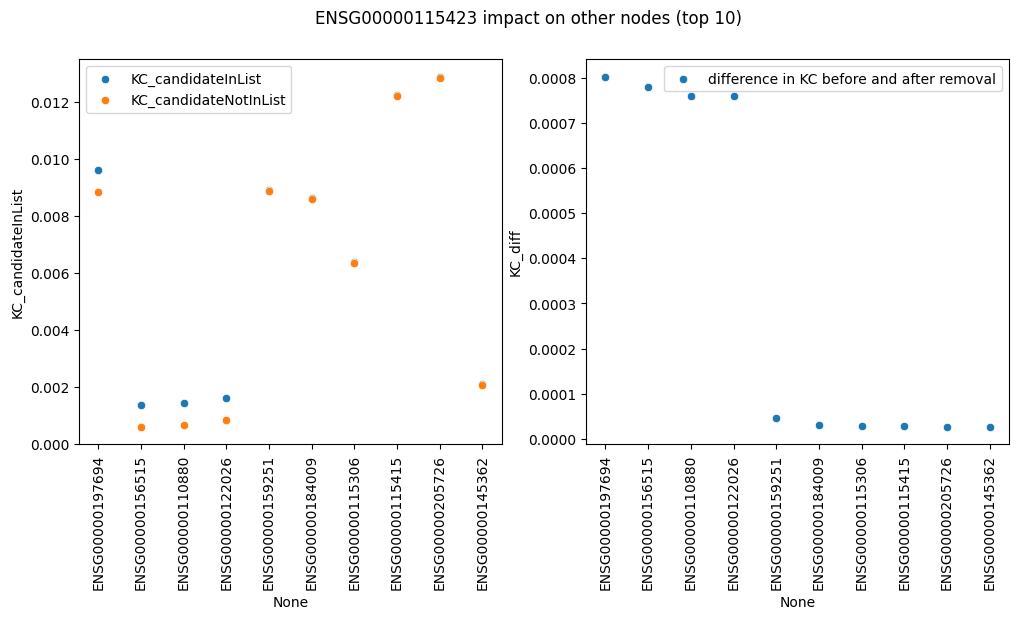

In [13]:
# plot top 10 most affected genes by a given candidate
candidate_of_interest = 'ENSG00000115423'

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{candidate_of_interest} impact on other nodes (top 10)')


df_top = pd.DataFrame.from_dict(dict_most_affected.get(candidate_of_interest), orient='index', columns=['KC_candidateInList', 'KC_candidateNotInList', 'KC_diff'])
sns.scatterplot(data=df_top, x=df_top.index, y='KC_candidateInList', ax=ax[0], label='KC_candidateInList')
sns.scatterplot(data=df_top, x=df_top.index, y='KC_candidateNotInList', ax=ax[0], label='KC_candidateNotInList')
ax[0].set_xticklabels(df_top.index, rotation=90)
ax[0].legend()

sns.scatterplot(data=df_top, x=df_top.index, y='KC_diff', ax=ax[1], label='difference in KC before and after removal')
ax[1].set_xticklabels(df_top.index, rotation=90)
ax[1].legend()

### Find how all the genes are affected by candidate removal

In [14]:
# create a dictionary for KC comparison
dict_compare = {}

# create a dictionary with the following structure for the most affected genes :
# {candidateLeftOout : {mostAffected : KC, 2ndMostAffected : KC, ...},
#   ...}
dict_all = {}

In [16]:
for candidate in candidates_MMAF:
    # remove the candidate from candidate list
    left_out_idx = candidates_MMAF.index(candidate)

    candidates_MMAF_new = candidates_MMAF[:left_out_idx] + candidates_MMAF[left_out_idx+1:]

    print(f"Removed gene {candidate} from candidates")

    # set beta parameter for each node
    beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])

    # calculate Katz centrality for each node
    res_KC_candidateInList = katz_centrality(G, alpha=alpha, beta=beta_dict)
    res_KC_candidateInList_sorted = dict(sorted(res_KC_candidateInList.items(), key=lambda v: v[1], reverse=True))

    # compare KC of each node before and after removal of candidate
    for idx, row in df.iterrows():
        KC_candidateInList = row['KC']
        KC_candidateNotInList = res_KC_candidateInList_sorted.get(idx)
        KC_diff = KC_candidateInList - KC_candidateNotInList

        dict_compare[idx] = {"KC_candidateInList": KC_candidateInList, "KC_candidateNotInList": KC_candidateNotInList, "KC_diff": KC_diff}

    df_compare = pd.DataFrame.from_dict(dict_compare, orient='index', columns=['KC_candidateInList', 'KC_candidateNotInList', 'KC_diff'])
    df_compare = df_compare.sort_values(by='KC_diff', ascending=False)

    # do not include the candidate itself as the highest scoring node
    df_all = df_compare.iloc[1:]

    dict_all[candidate] = df_all.to_dict('index')

Removed gene ENSG00000111254 from candidates
Removed gene ENSG00000147081 from candidates
Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000185658 from candidates
Removed gene ENSG00000135205 from candidates
Removed gene ENSG00000109881 from candidates
Removed gene ENSG00000161973 from candidates
Removed gene ENSG00000139537 from candidates
Removed gene ENSG00000174799 from candidates
Removed gene ENSG00000272514 from candidates
Removed gene ENSG00000206530 from candidates
Removed gene ENSG00000165164 from candidates
Removed gene ENSG00000120051 from candidates
Removed gene ENSG00000181378 from candidates
Removed gene ENSG00000105792 from candidates
Removed gene ENSG00000142609 from candidates
Removed gene ENSG00000183833 from candidates
Removed gene ENSG00000167646 from candidates
Removed gene ENSG00000197653 from candidates
Removed gene ENSG00000158486 from candidates
Removed gene ENSG00000197653 from candidates
Removed gene ENSG00000187775 from candidates
Removed ge

In [17]:
# save the results
with open('interactome_analysis/MMAF/dict_KC_all_MMAF.p', 'wb') as handle:
    pickle.dump(dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# and load the dictionary back
with open('interactome_analysis/MMAF/dict_KC_all_MMAF.p', 'rb') as handle:
    dict_all = pickle.load(handle)

#### sanity check

In [21]:
len(dict_most_affected.get('ENSG00000111254').keys())

10

In [22]:
len(dict_all.get('ENSG00000111254').keys())

14464

### Analyze the results: most affected

In [57]:
# find the gene with the highest difference in KC
highest_KC_diff = 0

for candidate, most_affected in dict_most_affected.items():
    df_tmp = pd.DataFrame.from_dict(dict_most_affected.get(candidate), orient='index')
    if df_tmp.iloc[0]['KC_diff'] > highest_KC_diff:
        highest_KC_diff_candidate = candidate
        highest_KC_diff_gene = df_tmp.index[0]
        highest_KC_diff = df_tmp.iloc[0]['KC_diff']

In [58]:
highest_KC_diff_candidate, highest_KC_diff_gene, highest_KC_diff

('ENSG00000174799', 'ENSG00000046651', 0.0019735449141220947)

/tmp/ipykernel_16309/2836371915.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_top.index, rotation=90)
/tmp/ipykernel_16309/2836371915.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_top.index, rotation=90)


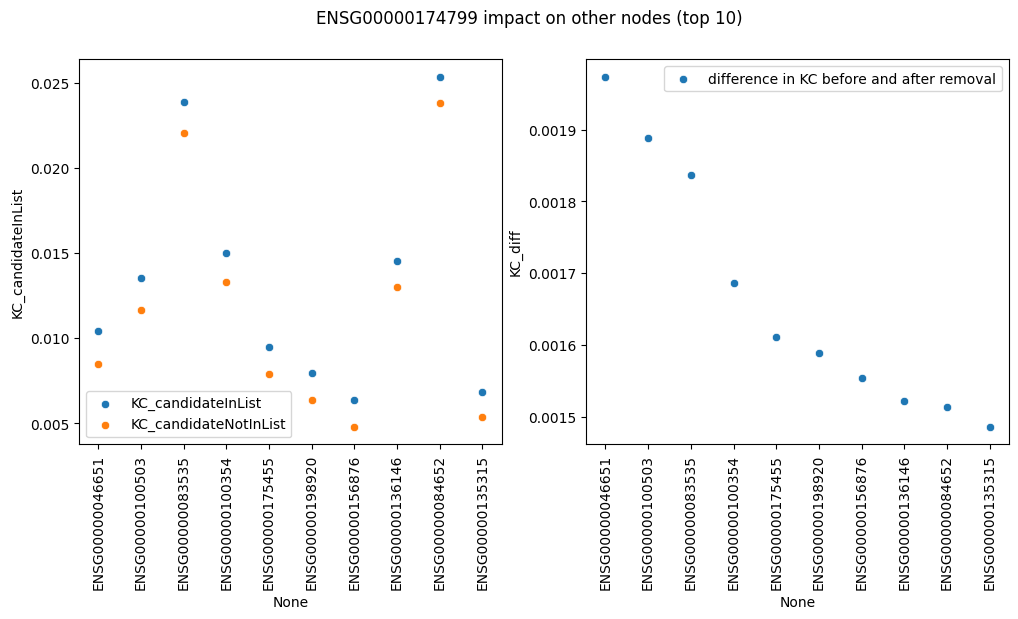

In [59]:
# plot top 10 most affected genes by a given candidate
candidate_of_interest = 'ENSG00000174799'

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{candidate_of_interest} impact on other nodes (top 10)')


df_top = pd.DataFrame.from_dict(dict_most_affected.get(candidate_of_interest), orient='index', columns=['KC_candidateInList', 'KC_candidateNotInList', 'KC_diff'])
sns.scatterplot(data=df_top, x=df_top.index, y='KC_candidateInList', ax=ax[0], label='KC_candidateInList')
sns.scatterplot(data=df_top, x=df_top.index, y='KC_candidateNotInList', ax=ax[0], label='KC_candidateNotInList')
ax[0].set_xticklabels(df_top.index, rotation=90)
ax[0].legend()

sns.scatterplot(data=df_top, x=df_top.index, y='KC_diff', ax=ax[1], label='difference in KC before and after removal')
ax[1].set_xticklabels(df_top.index, rotation=90)
ax[1].legend()